In [1]:
using MAT , Images , PyPlot
using LinearAlgebra , Statistics , StatsBase , Clustering

## Convert image to matrix

In [2]:
function get_Z(img)
    width , length = size(img) ;
    n = width*length ;
    # ColorNorm = zeros(n) ;
    # PixelNorm  = zeros(n) ;
    
    Z = zeros(n , 5) ;
    t = 1 ;
    for ii = 1 : width
        for jj = 1 : length
            # RGB
            Z[t,1] = img[ii,jj].r  ;
            Z[t,2] = img[ii,jj].g ;
            Z[t,3] = img[ii,jj].b ;
            
            # xy
            Z[t,4] = ii ;
            Z[t,5] = jj ;
            
            # ColorNorm[t] = Z[t,1]^2 + Z[t,2]^2 + Z[t,3]^2 ;
            # PixelNorm[t]  = Z[t,4]^2 + Z[t,5]^2 ;
            t += 1 ;
        end
    end
    
    Z[: , 4:5] ./= (width + length)/2 ;
    
    return Z ;
    
end

get_Z (generic function with 1 method)

## Nystrom

Given data set $ Z = \{z_1 , z_2 , ... , z_n\} \subseteq \mathbb{R}^n $ ,partition $ Z = X \cup Y $ where $X$ is randomly chosen in $Z$, size($X$) = L, define $ W_{xx} , W_{xy} $
$$ W_{xx} = [k(x_i,x_j)]_{L\times L} , x_i , x_j \in X $$
$$ W_{xy} = [k(x_i,y_j)]_{L\times (n-L)} , x_i \in X , y_j \in Y $$
where k(x,y) is Gaussian kernel. Note that $ W_{yx} = W_{xy}^T $.

In [3]:
function get_W(X , m , idx)
    n , d = size(Z) ;    
    Wxx = ones(m , m) ;
    Wxy = ones(m , n-m) ;
    
    # clasify and get K
    # single scaling
    pos1 = 1 ;
    pos2 = 1 ;
    for ii = 1 : n
        if pos1 <= m && ii == idx[pos1]
            for jj = 1 : m
                Wxx[jj,pos1] = sum((X[ii,:] - X[idx[jj],:]).^2) ;
            end
            pos1 += 1 ;
        else
            for jj = 1 : m
                Wxy[jj,pos2] = sum((X[ii,:] - X[idx[jj],:]).^2) ;
            end
            pos2 += 1 ;
        end
    end
    
    # single scaling
    m = Int(round(0.2 * n)) ; 
    temp = sort([Wxx Wxy] , dims = 2 , alg = QuickSort) ;
    temp = mean(temp[:,1:m] , dims = 2) ;
    sigma = median(temp) ;
    Wxx = exp.(-Wxx ./ sigma) ;
    Wxy = exp.(-Wxy ./ sigma) ;
    
    return Wxx , Wxy ;
end

get_W (generic function with 1 method)

Define $$ d_x = W_{xx}\cdot 1_L + W_{xy}\cdot 1_{n-L} \\ d_y =  W_{yx}\cdot 1_L + (W_{yx} W_{xx}^{-1} W_{xy}) \cdot 1_{n-L} $$
and $$ s_x = \sqrt{d_x},  s_y = \sqrt{d_y} $$
Normalize $W_{xx}$ and $W_{xy}$ :
$$ \bar{W_{xx}} = W_{xx} ./ (s_x\cdot s_x^T) \\ \bar{W_{xy}} = W_{xy} ./ (s_x\cdot s_y^T) $$
where operator ./ is component-wise division.

In [4]:
function normalize(Wxx , Wxy)
    dx = sum(Wxx , dims = 2) + sum(Wxy , dims = 2) ;
    # Here Wyx*pinv(Wxx)*Wxy may cause OutOfMemory error since y too large
    dy = sum(Wxy , dims = 1) + sum(transpose(Wxy)*pinv(Wxx) , dims = 1) * Wxy ;
    sx = sqrt.(dx) ;
    sy = sqrt.(dy) ;
    
    Wxx = (Wxx ./ sx) ./ transpose(sx) ; 
    Wxy = (Wxy ./ sx) ./ sy ;
    
    return Wxx , Wxy , sx , transpose(sy) ;
end

normalize (generic function with 1 method)

1. Apply SVD $$ B_x\Gamma B_x^T = W_{xx} $$
2. Compute $$ S = B_x \Gamma ^{-\frac{1}{2}} B_x^T \, \ Q = W_{xx} + S(W_{xy}W_{yx})S $$
3. Apply SVD $$ A\Xi A^T = Q $$
4. Compute 
$$ \Phi = \left [ \begin{array}{cc}
B_x\Gamma^{\frac{1}{2}}  \\
W_{yx}B_x\Gamma^{-\frac{1}{2}}
\end{array} \right ]B_x^T(A\Xi^{-\frac{1}{2}}) $$

Then $\Phi$ are the eigenvectors and diagonal of $\Xi$ are eigenvalues approximate to those of W. 

In [5]:
function get_eig(Wxx , Wxy , c)
    
    Bx , Gm , ~ = svd(Wxx) ;
    Gmsq = diagm(sqrt.(Gm)) ;
    Gmsqinv = diagm(sqrt.(1 ./ Gm)) ;
    S = Bx * Gmsqinv * transpose(Bx) ;
    Q = Wxx + S*(Wxy * transpose(Wxy))*S ;
    
    A , Xi , ~ = svd(Q) ;
    
    # Here we boost the computation
    # Phi = [Bx*Gmsq ; transpose(Wxy)*(Bx*Gmsqinv)] * (transpose(Bx) * A ./ transpose(sqrt.(Xi))) ;
    Phi = [Wxx ; transpose(Wxy)] *(Bx * Gmsqinv * transpose(Bx)* A ./ transpose(sqrt.(Xi))) ;
    
    # find recommend cluster with threshold 0.85
    cluster = 0 ;
    while cluster < size(Xi,1)-1 && Xi[cluster+2] > 0.85
        cluster += 1 ;
    end
    
    cluster = minimum([c , maximum([cluster,2])]) ;
    
    return Phi[: , 2:c+1] , Xi[2:c+1] , Int(cluster) ;
    
end

get_eig (generic function with 1 method)

## Combination of Nystrom

In [6]:
function Nystrom(Z , m , c)
    n = size(Z,1) ;
    
    # sampling some points of data
    idx = sort(sample(1:n , m , replace = false)) ;
    
    # construct part of diffusion matrix K
    print("get_W :") ;
    @time Wxx , Wxy = get_W(Z , m , idx) ;
    
    # normalize as P_pron
    print("normalize :") ;
    @time Wxx , Wxy , sx , sy = normalize(Wxx , Wxy) ;
    
    
    # find approximate eigenvalue and eigenvectors of P
    print("get_eig :") ;
    @time v , lambda , cluster = get_eig(Wxx , Wxy , c) ;
    v = v ./ [sx ; sy] ;
    
    # release memory
    Wxx = 0 ;
    Wxy = 0 ;
    sx  = 0 ;
    sy  = 0 ;
    
    # construct diffusion map
    Y = v .* transpose(lambda) ;
    
    # refresh order
    sort_Y = zeros(n , c) ;
    pos1 = 1 ;
    pos2 = 1 ;
    for ii = 1 : n
        if pos2 <= m && ii == idx[pos2]
            sort_Y[ii , :] = Y[idx[pos2] , :] ;
            pos2 += 1 ;
        else
            sort_Y[ii , :] = Y[pos1 + m , :] ;
            pos1 += 1 ;
        end
    end
    
    print("recommend cluster = " , cluster , " with threshold 0.85") ;
    
    return sort_Y , cluster ;

end

Nystrom (generic function with 1 method)

## Plot diffusion maps

In [7]:
function diff_plot(Y , group)
    dict1 = Dict(1 => "red" , 2 => "green" , 3 => "blue" , 4 => "orange" , 5 => "brown" , 6 => "cyan" , 7 => "black") ;

    cc = Array{String}(undef, size(group , 1)) ;
    for ii = 1 : size(group , 1)
        cc[ii] = dict1[group[ii]] ;
    end
    
    if size(Y,2) == 1
        scatter(1:size(Y,1) , Y , c = cc , s = 10) ;
    elseif size(Y,2) == 2
        scatter(Y[:,1] , Y[:,2] , c = cc , s = 10) ;
    else
        scatter3D(Y[:,1] , Y[:,2] , Y[:,3] , c = cc , s = 10) ;
    end
    
    return ;
end

diff_plot (generic function with 1 method)

## plot label in image

In [8]:
function img_label(h , w , label)
    YImg = Array{RGB{Float64},2}(undef,h,w) ;
    dict2 = Dict(1 => RGB(1,0,0) , 2 => RGB(0,1,0) , 3 => RGB(0,0,1) , 4 => RGB(0,0,0) , 5 => RGB(0.5,0.16,0.16) , 6 => RGB(0,1,1) , 7 => RGB(1,0.38,0)) ;

    t = 1 ;
    for ii = 1 : h
        for jj = 1 : w
            YImg[ii,jj] = dict2[label[t]] ;
            t += 1 ;
        end
    end
    
    return YImg ;

end

img_label (generic function with 1 method)

## Picture

┌ Info: Recompiling stale cache file C:\Users\asd95\.julia\compiled\v1.2\ImageMagick\0LbNX.ji for ImageMagick [6218d12a-5da1-5696-b52f-db25d2ecc6d1]
└ @ Base loading.jl:1240


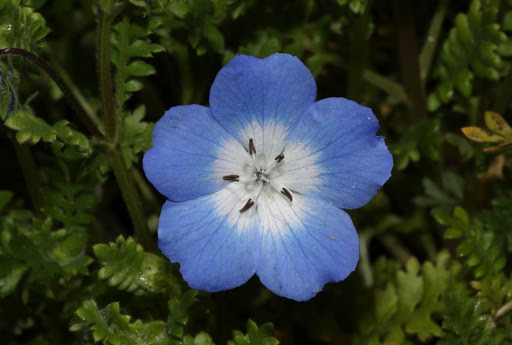

┌ Warning: `Stream(format"PNG", filename)` is deprecated, please use `Stream{format"PNG"}(filename)` instead.
│   caller = ip:0x0
└ @ Core :-1


In [9]:
img = load("test1.jpg") 

In [10]:
# apply Nystrom
m = 10 ; # sample 20 points
c = 3 ; # output 3-dims diffusion map

Z = get_Z(img) ;
Y , cluster = Nystrom(Z , m , c) ;

get_W :  3.023169 seconds (31.18 M allocations: 1.417 GiB, 8.04% gc time)
normalize :  1.352190 seconds (4.25 M allocations: 238.060 MiB, 6.15% gc time)
get_eig :  0.436513 seconds (1.50 M allocations: 105.107 MiB, 8.60% gc time)
recommend cluster = 2 with threshold 0.85

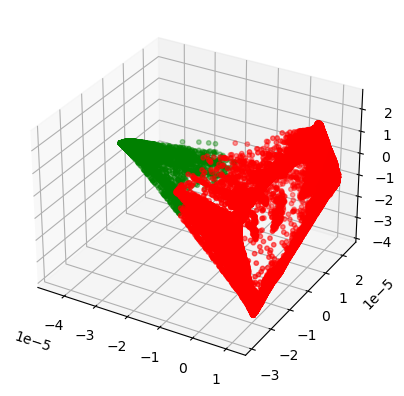

In [11]:
# apply k-means
cluster = 2 ;
Rdata = kmeans(transpose(Y) , cluster) ;
group = Rdata.assignments ;

diff_plot(Y , group) ;

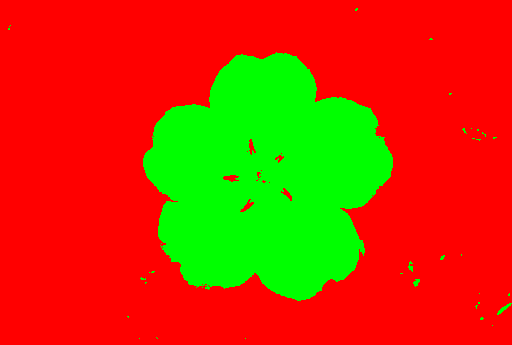

In [12]:
h = size(img,1) ;
w = size(img,2) ;

Yimg = img_label(h , w , group)

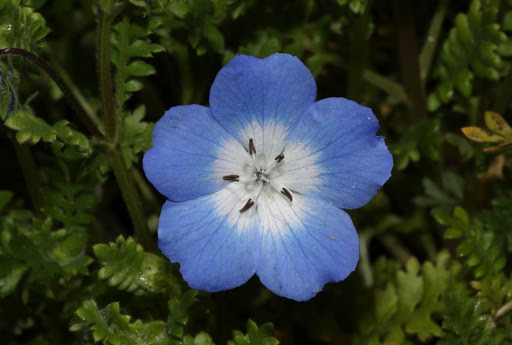

In [13]:
img